In [1]:
import sys
import pandas
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

### Download and read training and test files

In [2]:
!wget https://www.dropbox.com/s/pi19mrgx576pr6a/test.csv
!wget https://www.dropbox.com/s/dvdi4churq4tcqe/training.csv

wget: /root/miniconda/envs/rep_py3/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py3/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-12-18 14:49:32--  https://www.dropbox.com/s/pi19mrgx576pr6a/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/C5Bn4myH4rvyr44nZJW2e6wGSIiVNSDbSvU28bfnv0lnVhyB10a5R4jcB8W7OOth/file [following]
--2016-12-18 14:49:34--  https://dl.dropboxusercontent.com/content_link/C5Bn4myH4rvyr44nZJW2e6wGSIiVNSDbSvU28bfnv0lnVhyB10a5R4jcB8W7OOth/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [10]:
data = pandas.read_csv('training.csv')
test = pandas.read_csv('test.csv')

Делаем кучу новых признаков. Больше не меньше! Если что-то будет лишнее, разберёмся с этим позже.

In [11]:
data['Rapidity'] = np.log( (np.sqrt(data['Mass']**2 + data['Pt']**2*np.cosh(data['Pseudorapidity'])**2) + 
                data['Pt']*np.sinh(data['Pseudorapidity']))/(np.sqrt(data['Mass']**2 + data['Pt']**2)) )
data['Rapidity_corrected'] = np.log( (np.sqrt(data['Corrected_mass']**2 + data['Pt']**2*np.cosh(data['Pseudorapidity'])**2) + 
                data['Pt']*np.sinh(data['Pseudorapidity']))/(np.sqrt(data['Corrected_mass']**2 + data['Pt']**2)) )
data['Pz'] = np.sinh(data['Pseudorapidity'])*data['Pt']
data['P'] = np.cosh(data['Pseudorapidity'])*data['Pt']
data['E'] = np.sqrt(data['P']**2 + data['Mass']**2)
data['E_corrected'] = np.sqrt(data['P']**2 + data['Corrected_mass']**2)
data['Pt_0'] = data['Pt'] - data['Pt_min']
data['gamma'] = data['E']/data['Mass']
data['gamma_corr'] = data['E_corrected']/data['Corrected_mass']
data['beta'] = np.sqrt(1 - 1/data['gamma']**2)
data['beta_corr'] = np.sqrt(1 - 1/data['gamma_corr']**2)
data['t'] = data['Flight_distance']/data['beta']
data['t_corr'] = data['Flight_distance']/data['beta_corr']
data['pt_coll'] = data['Pt_sum']/data['Pt']
data['E_div'] = data['E']/data['E_corrected']
data['M_div'] = data['Mass']/data['Corrected_mass']
data['gamma_div'] = data['gamma']/data['gamma_corr']
data['beta_div'] = data['beta']/data['beta_corr']

data['track_div'] = data['Tracks_number_passed']/data['Tracks_number']



test['Rapidity'] = np.log( (np.sqrt(test['Mass']**2 + test['Pt']**2*np.cosh(test['Pseudorapidity'])**2) + 
                test['Pt']*np.sinh(test['Pseudorapidity']))/(np.sqrt(test['Mass']**2 + test['Pt']**2)) )
test['Rapidity_corrected'] = np.log( (np.sqrt(test['Corrected_mass']**2 + test['Pt']**2*np.cosh(test['Pseudorapidity'])**2) + 
                test['Pt']*np.sinh(test['Pseudorapidity']))/(np.sqrt(test['Corrected_mass']**2 + test['Pt']**2)) )
test['Pz'] = np.sinh(test['Pseudorapidity'])*test['Pt']
test['P'] = np.cosh(test['Pseudorapidity'])*test['Pt']
test['E'] = np.sqrt(test['P']**2 + test['Mass']**2)
test['E_corrected'] = np.sqrt(test['P']**2 + test['Corrected_mass']**2)
test['Pt_0'] = test['Pt'] - test['Pt_min']
test['gamma'] = test['E']/test['Mass']
test['gamma_corr'] = test['E_corrected']/test['Corrected_mass']
test['beta'] = np.sqrt(1 - 1/test['gamma']**2)
test['beta_corr'] = np.sqrt(1 - 1/test['gamma_corr']**2)
test['t'] = test['Flight_distance']/test['beta']
test['t_corr'] = test['Flight_distance']/test['beta_corr']
test['pt_coll'] = test['Pt_sum']/test['Pt']
test['E_div'] = test['E']/test['E_corrected']
test['M_div'] = test['Mass']/test['Corrected_mass']
test['gamma_div'] = test['gamma']/test['gamma_corr']
test['beta_div'] = test['beta']/test['beta_corr']

test['track_div'] = test['Tracks_number_passed']/test['Tracks_number']


features = list(set(data.columns) - {'EventID', 'Label', 'Weight'})
print (features)
print (len(features))

['Pt_0', 'Rapidity_corrected', 'E', 'Rapidity', 'Pz', 't', 'IP_chi2', 'E_div', 'E_corrected', 'pt_coll', 't_corr', 'Tracks_number_passed', 'Pt_sum', 'P', 'Flight_distance', 'beta_div', 'Vertex_chi2', 'track_div', 'Pseudorapidity', 'gamma_corr', 'gamma_div', 'Pt', 'Pt_min', 'Tracks_number', 'M_div', 'IP_chi2_sum', 'beta', 'Corrected_mass', 'Track_number_PV', 'gamma', 'beta_corr', 'Mass']
32


In [12]:
import copy
from sklearn.cross_validation import KFold, StratifiedKFold
class stacking:
    def __init__(self, clf, n):
        self.clf = list()
        for i in range(n):
             self.clf.append(copy.deepcopy(clf))
        self.n = n
    def fit_predict_proba(self, X, y, groups = None):
        kf = StratifiedKFold(y, n_folds=self.n)
        predictions = np.zeros((len(y),))
        i = 0
        for train_index, test_index in kf:
            self.clf[i].fit(X[train_index,:], y[train_index])
            predictions[test_index] = (self.clf[i].predict_proba(X[test_index,:]))[:, 1]
            i += 1
        return predictions
    def predict_proba(self, X):
        predictions = np.zeros((X.shape[0],))
        for i in range(self.n):
            predictions += self.clf[i].predict_proba(X)[:, 1]
        predictions = predictions/self.n
        return predictions

# Стекинг!

А давайте затренируем 3 xgboost с абсолютно разными параметрами и посмотрим, что получится.

In [13]:
pred_stack_1 = stacking(clf=XGBClassifier(max_depth=100, n_estimators=6, learning_rate=0.3, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
pred_train_1 = pred_stack_1.fit_predict_proba(data[features].values, data.Label.values)
pred_test_1 = pred_stack_1.predict_proba(test[features].values)

data['predictions_1'] = pred_train_1
test['predictions_1'] = pred_test_1

In [14]:
pred_stack_2 = stacking(clf=XGBClassifier(max_depth=20, n_estimators=25, learning_rate=0.1, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
pred_train_2 = pred_stack_2.fit_predict_proba(data[features].values, data.Label.values)
pred_test_2 = pred_stack_2.predict_proba(test[features].values)

data['predictions_2'] = pred_train_2
test['predictions_2'] = pred_test_2

In [15]:
pred_stack = stacking(clf=XGBClassifier(max_depth=6, n_estimators=250, learning_rate=0.03, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.9, reg_alpha=1), n=10)
pred_train_3 = pred_stack.fit_predict_proba(data[features].values, data.Label.values)
pred_test_3 = pred_stack.predict_proba(test[features].values)

data['predictions_3'] = pred_train_3
test['predictions_3'] = pred_test_3

In [46]:
fscores = pred_stack_2.clf[0].booster().get_fscore()
importances = np.zeros(len(fscores))
for k, v in fscores.items():
    importances[int(k[1:])] = v

Самая бесполезная фича импульс, Track_number_PV и Track_number. Первое удивительно, вторые две, в принципе, ожидаемо.

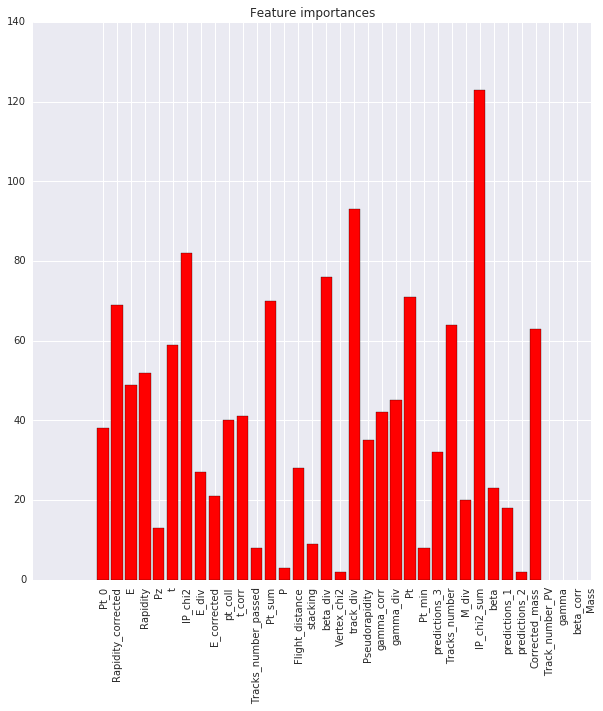

In [47]:
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances,
       color="r", align="center")
plt.xticks(range(len(features)), features, rotation=90)
plt.xlim()
plt.show()

# Магическое усреднение
Некая магическая формула, которая работает. Смысл можно понять так: это нечто вроде геометрического среднего, но не совсем.
Все классификаторы очень уверенные, а потому просто складывать и усреднять эти предсказания хорошо, но ещё лучше перемножать.

Под сильным классификатором я подразумеваю такой, который даёт очень смещённые к 1 предсказания. Для них хорошо перемножать вероятности.

In [22]:
!pip -q install seaborn

(0, 1)

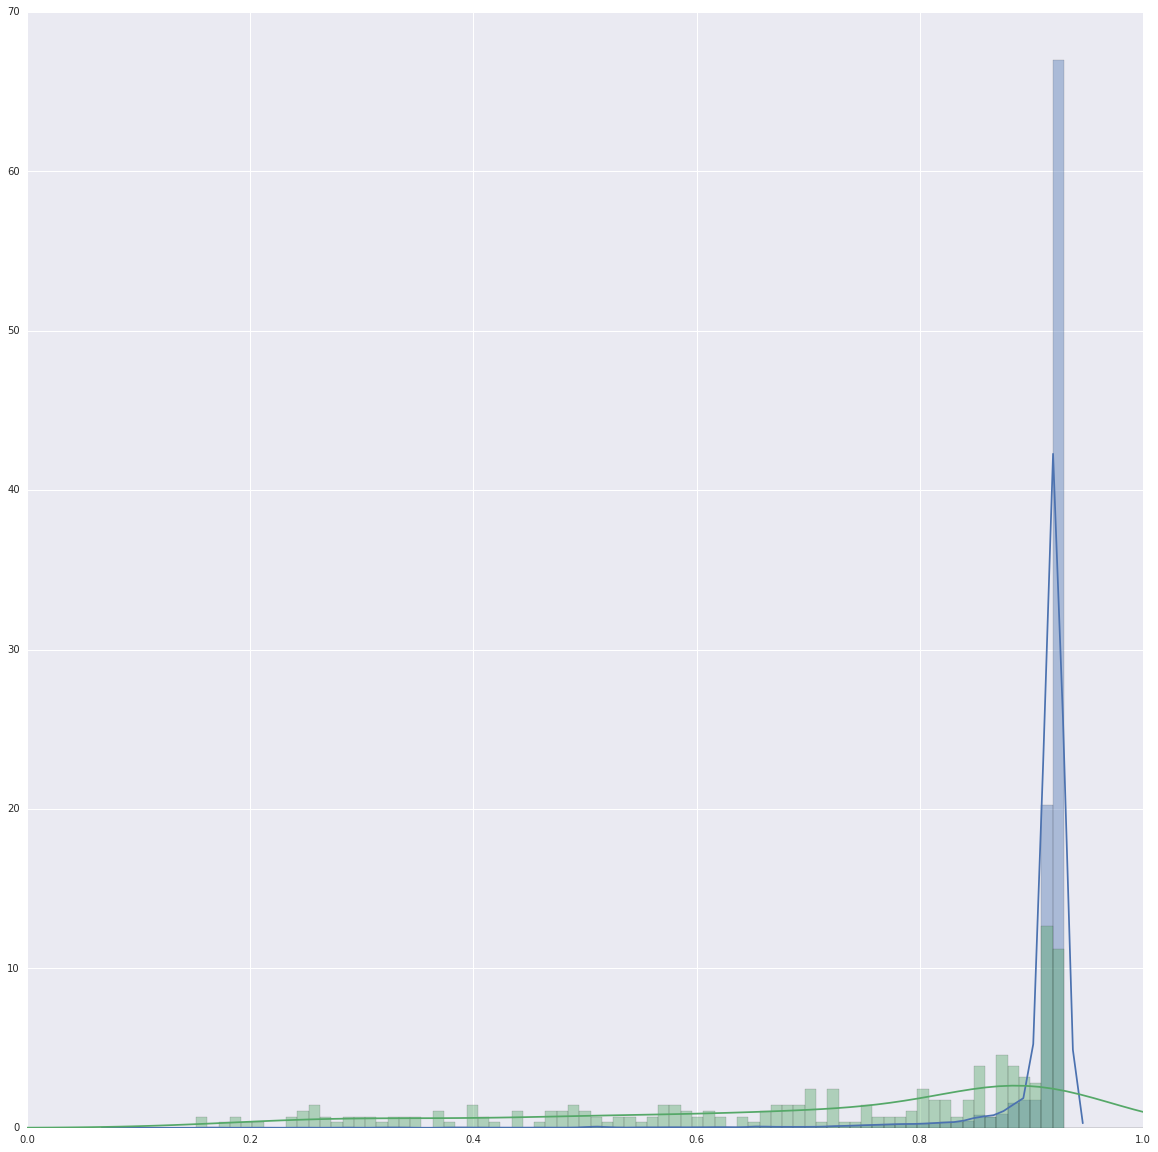

In [23]:
import seaborn as sns
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = signal_hits['predictions_1'].values
points2 = noise_hits['predictions_1'].values

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

In [24]:
data['stacking'] = data['predictions_1']**0.1*data['predictions_2']**1.9*data['predictions_3']
test['stacking'] = test['predictions_1']**0.1*test['predictions_2']**1.9*test['predictions_3']

Посмотрим на график стэкинга. Вот, другое дело:)

(0, 1)

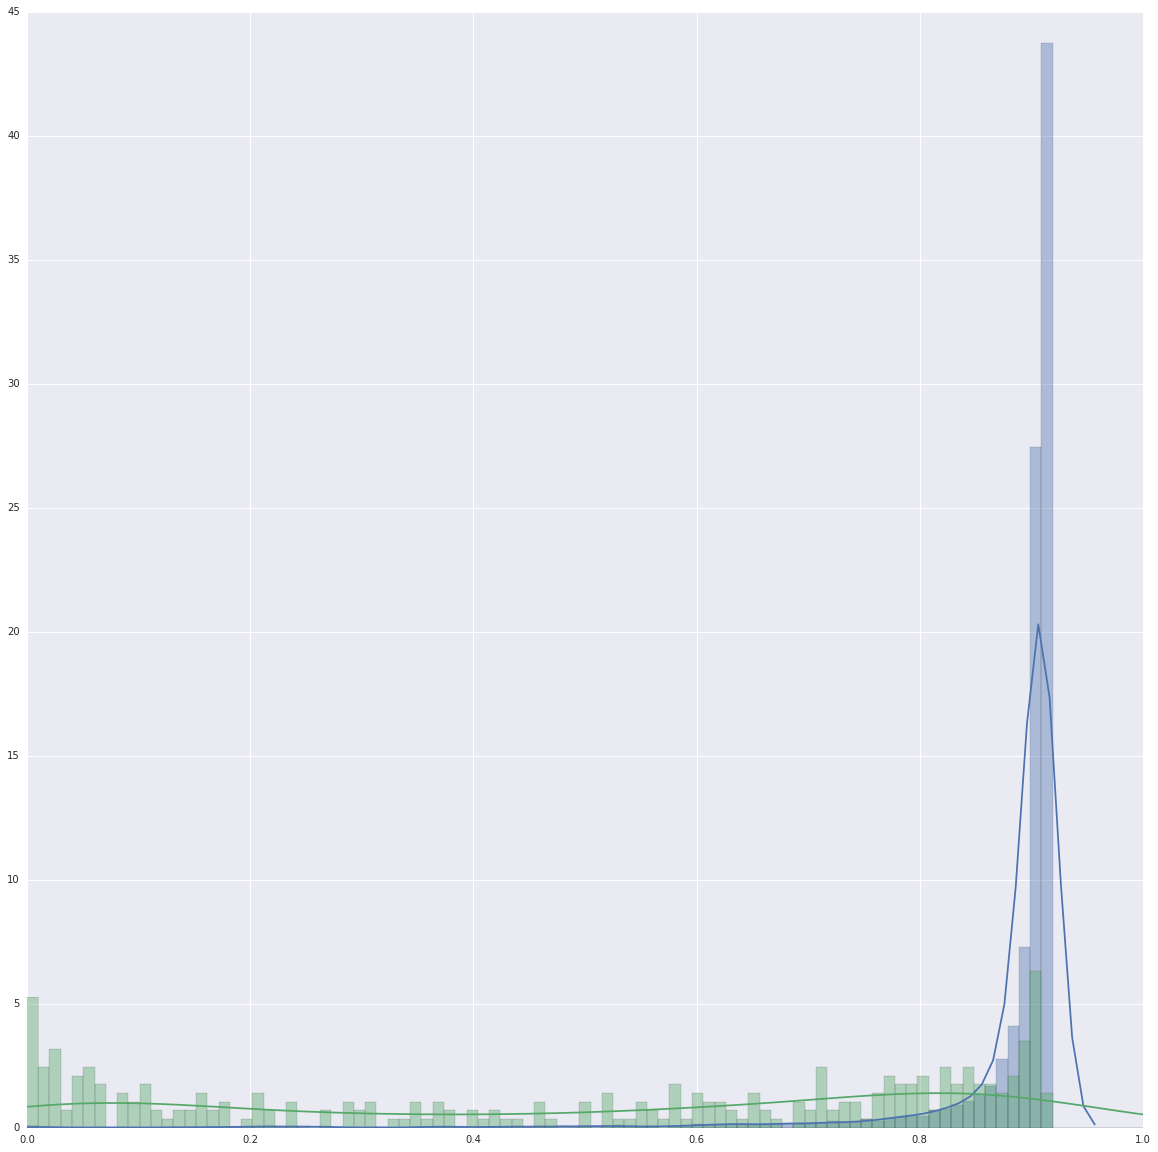

In [25]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = signal_hits['stacking'].values
points2 = noise_hits['stacking'].values

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

In [26]:
features = list(set(data.columns) - {'EventID', 'Label', 'Weight'})

print (features)
print (len(features))

['Pt_0', 'Rapidity_corrected', 'E', 'Rapidity', 'Pz', 't', 'IP_chi2', 'E_div', 'E_corrected', 'pt_coll', 't_corr', 'Tracks_number_passed', 'Pt_sum', 'P', 'Flight_distance', 'stacking', 'beta_div', 'Vertex_chi2', 'track_div', 'Pseudorapidity', 'gamma_corr', 'gamma_div', 'Pt', 'Pt_min', 'predictions_3', 'Tracks_number', 'M_div', 'IP_chi2_sum', 'beta', 'predictions_1', 'predictions_2', 'Corrected_mass', 'Track_number_PV', 'gamma', 'beta_corr', 'Mass']
36


# Постановка новой задачи

Классифицировать эвенты по отдельным реакциям очень странно. Хорошо было бы как-то сделать признаки для события как единого целого. Начнём с квантилей.

In [28]:
data_grouped = data.groupby('EventID')

X_data_min = data_grouped[features].min().values
data_grouped_max = data_grouped[features].max()
print ('Finished 0q')
X_data_max = data_grouped_max.values
print ('Finished 100q')
data_grouped_25 = data_grouped[features].quantile(q=0.25)
X_data_q25 = data_grouped_25.values
print ('Finished 25q')
data_grouped_median = data_grouped[features].median()
X_data_q50 = data_grouped_median.values
print ('Finished 50q')
data_grouped_75 = data_grouped[features].quantile(q=0.75)
X_data_q75 = data_grouped_75.values
print ('Finished 75')


test_grouped_test = test.groupby('EventID')

X_test_min = test_grouped_test[features].min().values
print ('Finished 0q test')
test_grouped_max = test_grouped_test[features].max()
X_test_max = test_grouped_max.values
print ('Finished 100q test')
test_grouped_25 = test_grouped_test[features].quantile(q=0.25)
X_test_q25 = test_grouped_25.values
print ('Finished 25q test')
test_grouped_median = test_grouped_test[features].median()
X_test_q50 = test_grouped_median.values
print ('Finished 50q test')
test_grouped_75 = test_grouped_test[features].quantile(q=0.75)
X_test_q75 = test_grouped_75.valuesprint ('Finished 75q test')


Ok
Ok
Ok
Ok
Ok


In [29]:
X_data = np.concatenate((X_data_max, X_data_min, X_data_q25, X_data_q50, X_data_q75),
                       axis=1)
X_test = np.concatenate((X_test_max, X_test_min, X_test_q25, X_test_q50, X_test_q75),
                       axis=1)

def compute_mean(event_ids, values):
    number_of_sv_in_event = np.bincount(event_ids)
    return np.bincount(event_ids, weights=values) / number_of_sv_in_event

events_ids = np.unique(data.EventID)
events_labels = compute_mean(data.EventID, data.Label)[events_ids]

Кроме этого добавим отдельно реакции, которые будут "представителями" события.

In [30]:
idx = data.groupby(['EventID'])['stacking'].transform(max) == data['stacking']
idx_test = test.groupby(['EventID'])['stacking'].transform(max) == test['stacking']

In [31]:
X_rep_train = data.sort('stacking', ascending=False).groupby('EventID').first()[features].values
X_rep_test = test.sort('stacking', ascending=False).groupby('EventID').first()[features].values

/root/miniconda/envs/rep_py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/root/miniconda/envs/rep_py3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [32]:
X_data = np.concatenate((X_data, X_rep_train),
                       axis=1)
X_test = np.concatenate((X_test, X_rep_test),
                       axis=1)

# Финальный ансамбль

In [33]:
fin_stack_1 = stacking(clf=XGBClassifier(max_depth=100, n_estimators=50, learning_rate=0.3, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_1 = fin_stack_1.fit_predict_proba(X_data, events_labels)
fin_test_1 = fin_stack_1.predict_proba(X_test)

In [34]:
fin_stack_2 = stacking(clf=XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.02, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_2 = fin_stack_2.fit_predict_proba(X_data, events_labels)
fin_test_2 = fin_stack_2.predict_proba(X_test)

In [35]:
fin_stack_3 = stacking(clf=XGBClassifier(max_depth=20, n_estimators=200, learning_rate=0.1, 
                                        silent=False, min_child_weight=1, 
             subsample=0.9, colsample_bytree=0.7, reg_alpha=1), n=10)
fin_train_3 = fin_stack_3.fit_predict_proba(X_data, events_labels)
fin_test_3 = fin_stack_3.predict_proba(X_test)

Здесь мы опять делаем тот же трюк, геометрическое усреднение.

In [36]:
train_stack_fin = fin_train_1**0.15*fin_train_2**3*fin_train_3**0.7
test_stack_fin = fin_test_1**0.15*fin_test_2**3*fin_test_3**0.7

## Prepare submission to kaggle

In [38]:
ids = np.arange(0, 1770,1)

ml_prediction = pd.DataFrame({
        "Label": test_stack_fin}, 
        index=ids)
ml_prediction.to_csv("ml.csv", index_label='EventID', float_format='%.16f')

(0, 1)

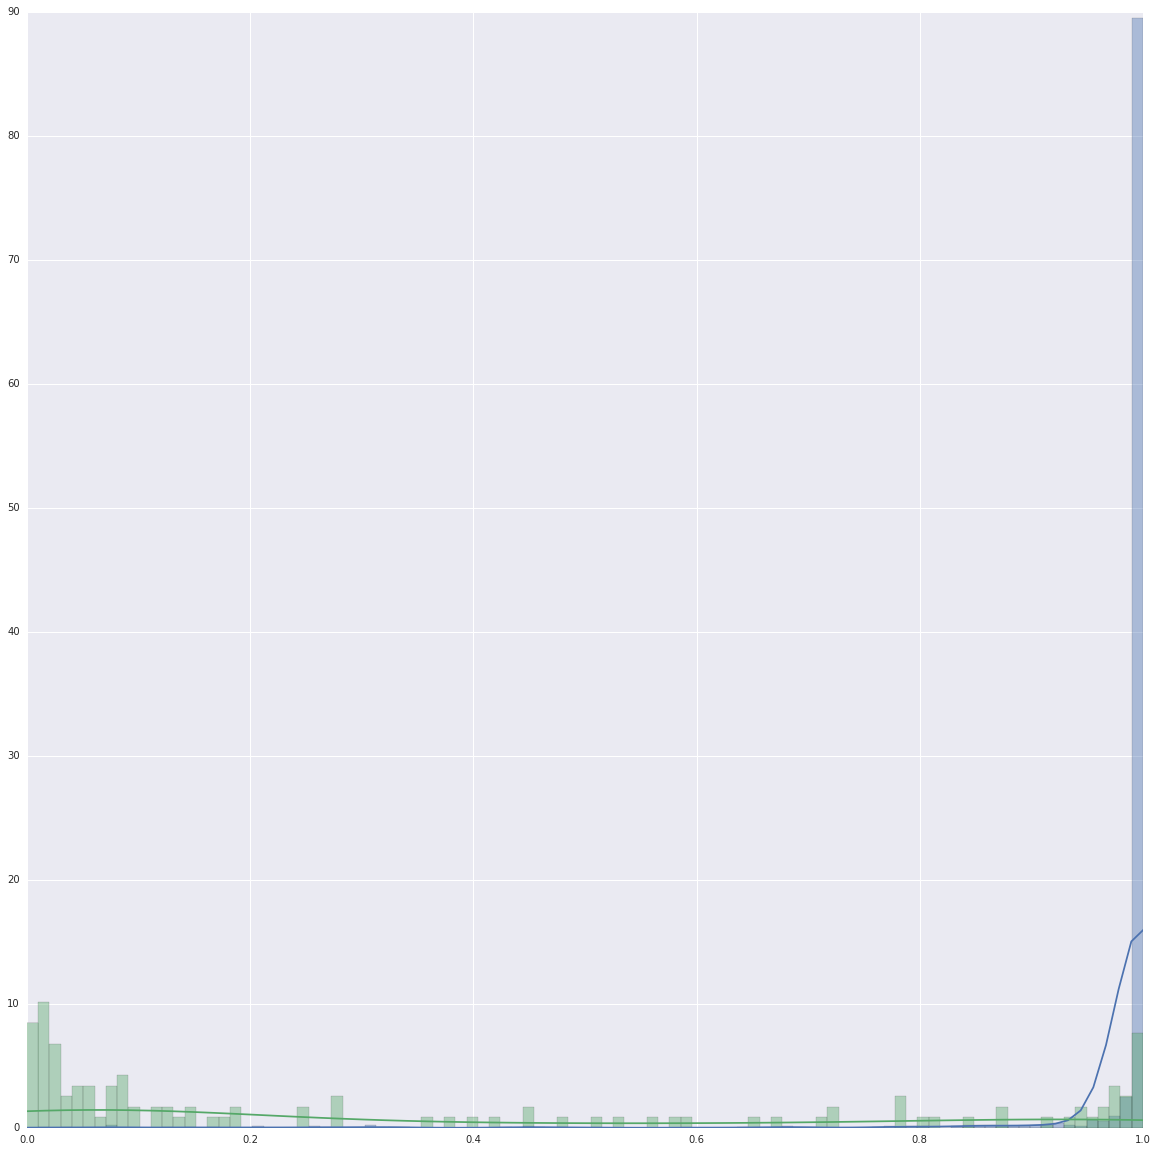

In [40]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = fin_train_2[events_labels == 1]
points2 = fin_train_2[events_labels == 0]

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))

(0, 1)

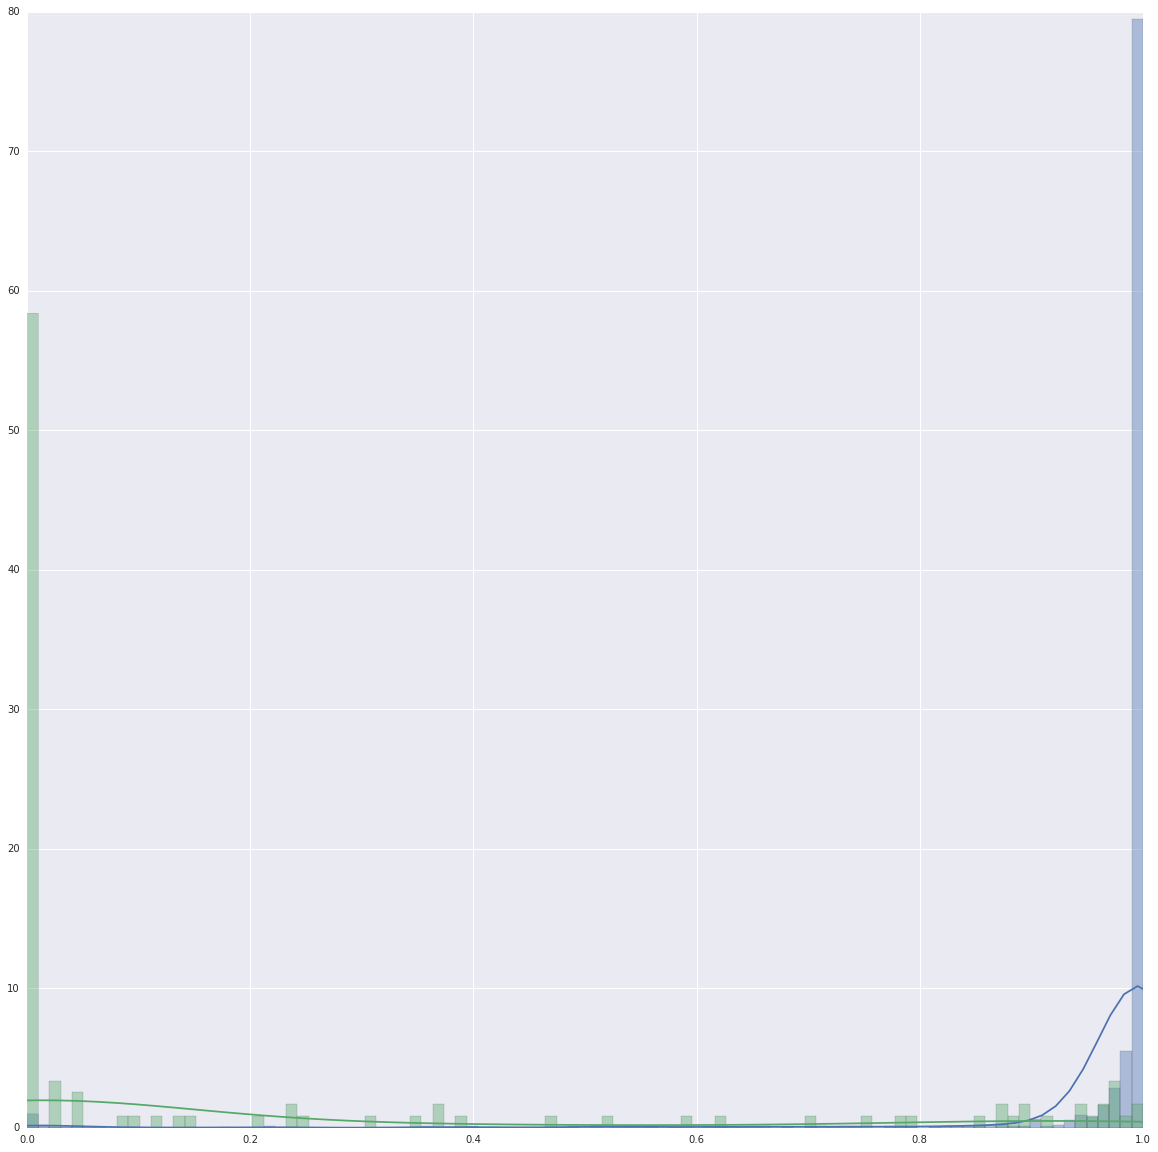

In [41]:
signal_hits = data.loc[(data.Label == 1)]
noise_hits = data.loc[(data.Label == 0)]
points1 = train_stack_fin[events_labels == 1]
points2 = train_stack_fin[events_labels == 0]

fig, ax = plt.subplots(figsize=(20,20))

sns.distplot(points1, bins=np.linspace(0,1,100));
sns.distplot(points2, bins=np.linspace(0,1,100));
plt.xlim((0,1))